In [16]:
'''

This notebook follows the PTDraft_with_4Segments_to_lines.ipynb notebook.

'''

'\n\nThis notebook follows the PTDraft_with_4Segments_to_lines.ipynb notebook.\n\n'

In [17]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from collections import defaultdict
from collections import deque
import imgShow as disp
import GrayWorld as gw
import PreProcess as prep
import time
from copy import deepcopy
from tqdm import tqdm
import multiprocessing
import IPython as IP
import HoughLines as hl
from itertools import islice

for i in [disp, gw, prep, hl]:
    importlib.reload(i)

In [18]:
a=1
b=a+1
IMAGE_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
exclude=[2, 3, 4, 5, 24, 19, 23, 27, 1, 6, 7, 8, 29, 20, 22, 25, 21, 17]
for i in exclude:
    IMAGE_list.pop(IMAGE_list.index(i))
b=30
store=[]
print (IMAGE_list)
print (len(IMAGE_list))

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 26, 28]
12


In [19]:
store

[]

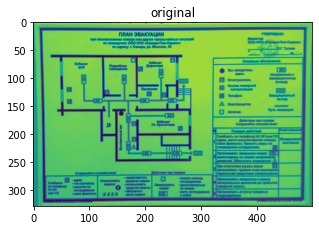

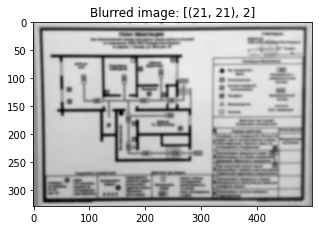

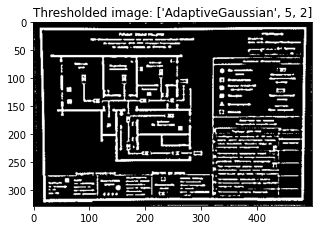

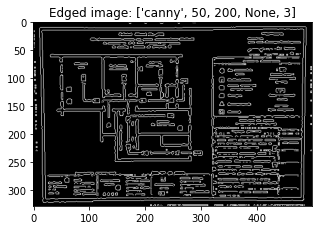

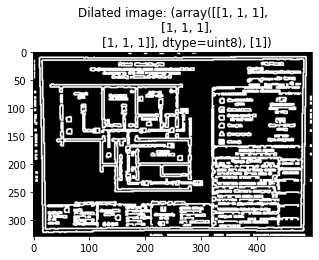

{0: 0, 1: 5, 178: 4, 89: 3, 179: 3, 2: 2, 3: 1, 177: 1}
{0: 0, 1: 5, 178: 4, 179: 3, 2: 2, 3: 1, 177: 1} {89: 3}
{0.6999520703723172: 10874276}
{89.0: 59049}


{0: 0, 177: 2, 2: 1, 91: 1, 92: 1, 179: 1}
{0: 0, 177: 2, 2: 1, 179: 1} {91: 1, 92: 1}
{177.00682261208578: 1026}
{91.5: 2}


{0: 0, 1: 2, 179: 2, 4: 1, 174: 1}
{0: 0, 1: 2, 179: 2, 4: 1, 174: 1} {}
{179.9990243902439: 2050}
{None: None}


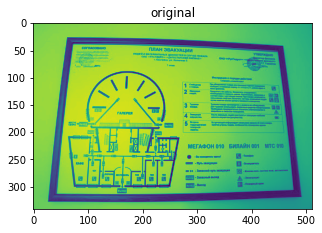

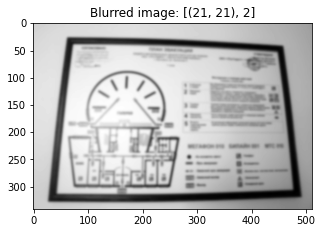

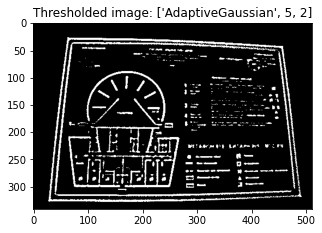

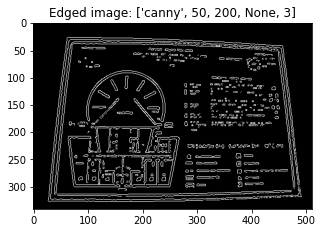

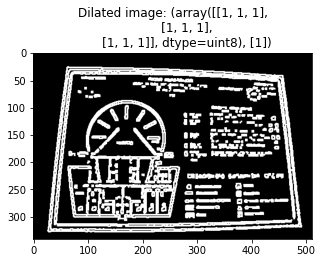

{1: 7, 2: 4, 82: 1, 96: 1, 97: 1, 0: 0}
{1: 7, 2: 4, 0: 0} {82: 1, 96: 1, 97: 1}
{1.0036983699694373: 283523825}
{91.66666666666667: 3}


{84: 6, 1: 3, 0: 0, 179: 2, 83: 1, 85: 1, 87: 1}
{1: 3, 0: 0, 179: 2} {84: 6, 83: 1, 85: 1, 87: 1}
{0.9659081450901403: 60073}
{84.00000004961451: 60466179}


{179: 12, 0: 0, 97: 4, 96: 3, 1: 1, 2: 1, 95: 1}
{179: 12, 0: 0, 1: 1, 2: 1} {97: 4, 96: 3, 95: 1}
{179.00000000008075: 61917364226}
{96.94668687806173: 1107626}


{0: 0, 179: 3, 175: 1}
{0: 0, 179: 3, 175: 1} {}
{178.99993226079593: 59050}
{None: None}


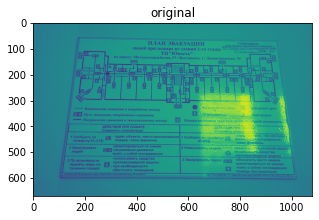

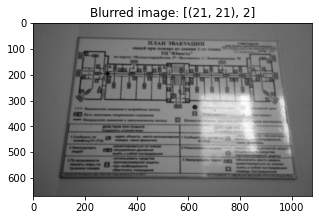

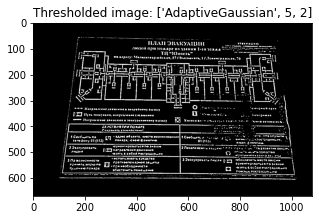

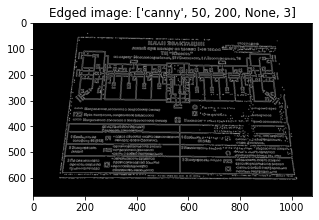

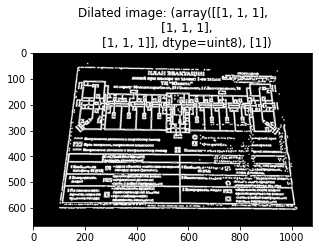

{0: 0, 1: 18, 178: 4, 179: 4, 4: 3, 175: 3, 177: 3, 2: 2, 3: 1, 5: 1, 174: 1}
{0: 0, 1: 18, 178: 4, 179: 4, 4: 3, 175: 3, 177: 3, 2: 2, 3: 1, 5: 1, 174: 1} {}
{0.9999984161186654: 3570469501950}
{None: None}


In [20]:
for IMAGE in IMAGE_list:
    cont=False

    try:
        path=f"../ForPerspectiveTransform/{IMAGE}.jpg"
        img=cv.imread(path)
        original=cv.imread(path)
        gray=cv.cvtColor (original, cv.COLOR_BGR2GRAY)
        prepped=prep.PreProcess(gray, edge=['canny', 50, 200, None, 3], dilate=[1])
        kernel=cv.getStructuringElement (cv.MORPH_RECT, ksize=(3, 3))
        prepped=cv.morphologyEx(prepped, cv.MORPH_OPEN, kernel=kernel, iterations=1)
        # disp.imgShow(prepped, title='Closed image')
        imglin, lines=hl.HoughLinesP(prepped, original.copy(), args=[1, np.pi/180, 40, 50, 1])
        qlines=hl.distLines (lines, prepped.shape)
        # angles, anglesPerLine = hl.findAngles (lines, tol=10)
        qangles, qanglesPerLine=[], []
        for i in range (4):
            j, k=hl.findAngles(qlines[i], tol=10)
            qangles.append(j)
            qanglesPerLine.append(k)
        qfirst=hl.getMax(list(qangles[0].values()), n=100)
        qsecond=hl.getMax(list(qangles[1].values()), n=100)
        qthird=hl.getMax(list(qangles[2].values()), n=100)
        qfourth=hl.getMax(list(qangles[3].values()), n=100)
        fp=[[], [], [], []]
        c=0

        for i in [qfirst, qsecond, qthird, qfourth]:
            print (i)
            ver, hor=hl.splitVH(i)
            print (ver, hor)
            for j in hl.makeAvg([ver, hor], weights='linear', power=10):
                print (j)
                if list(j.items())[0][0] is None or list(j.items())[0][1] is None:
                    store.append(f"Image {IMAGE} gave error")
                    cont=True
                    break
                fp[c].append(j)
            if cont:
                break
            c+=1
            print ("\n")
        if cont:
            continue
        temp=hl.makeTemplate(fp)
        p=hl.makePoint(temp, prepped, line=False)
        print (p)
        pp=np.int32(p)
        dst=hl.makeTrans(pp, cv.imread(path))
        predst=prep.PreProcess(dst, gray=False)
        cut=prep.clearVoid(dst, predst)
        cv.imwrite(f"../ToPerspectiveTransform/{IMAGE}.jpg", cut)
        IP.display.clear_output(True)

    except:
        store.append(f"Image {IMAGE} gave error")